In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.graph_objects as go
import talib as ta

pd.options.display.float_format = '{:.4f}'.format

import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")

In [2]:
def calcula_stop_atr(df, close_col, atr_col, desvio, periodo):
    """
    Calcula os valores de Stop ATR (Average True Range) para um DataFrame de dados financeiros.

    :param df: DataFrame contendo os dados.
    :param close_col: Nome da coluna do DataFrame contendo os valores de fechamento.
    :param atr_col: Nome da coluna do DataFrame contendo os valores de ATR (Average True Range).
    :param desvio: Valor do desvio a ser usado no cálculo do Stop ATR.
    :param periodo: Período a ser considerado no cálculo do Stop ATR.
    :return: DataFrame enriquecido com as colunas 'Stop ATR C' (para condições de compra) e 'Stop ATR V' (para condições de venda).
    """
    df = df.copy()
    
    # Calcula a diferença entre os valores de fechamento e o produto de ATR e desvio
    df['ATR_abs C'] = abs(close_col - (atr_col * desvio))
    df['Stop ATR_aux'] = np.NaN

    # Calcula os valores do Stop ATR C (para condições de compra)
    for i in range(len(df)):
        idx = df.index[i]
        if i >= periodo:
            if close_col.iloc[i] >= df['Stop ATR_aux'].iloc[i - 1]:
                if df['ATR_abs C'].iloc[i] > df['Stop ATR_aux'].iloc[i - 1]:
                    df.at[idx, 'Stop ATR_aux'] = df['ATR_abs C'].iloc[i]
                else:
                    df.at[idx, 'Stop ATR_aux'] = df['Stop ATR_aux'].iloc[i - 1]
            else:
                df.at[idx, 'Stop ATR_aux'] = df['ATR_abs C'].iloc[i]

    # Armazena o valor calculado do Stop ATR C e remove colunas intermediárias
    df['Stop ATR C'] = df['Stop ATR_aux'].shift(1)
    df = df.drop(['Stop ATR_aux', 'ATR_abs C'], axis=1)
    
    # Calcula a diferença entre os valores de fechamento e o produto de ATR e desvio
    df['ATR_abs V'] = abs(close_col + (atr_col * desvio))
    df['Stop ATR_aux'] = np.NaN

    # Calcula os valores do Stop ATR V (para condições de venda)
    for i in range(len(df)):
        idx = df.index[i]
        if i >= periodo:
            if close_col.iloc[i] < df['Stop ATR_aux'].iloc[i - 1]:
                if df['ATR_abs V'].iloc[i] < df['Stop ATR_aux'].iloc[i - 1]:
                    df.at[idx, 'Stop ATR_aux'] = df['ATR_abs V'].iloc[i]
                else:
                    df.at[idx, 'Stop ATR_aux'] = df['Stop ATR_aux'].iloc[i - 1]
            else:
                df.at[idx, 'Stop ATR_aux'] = df['ATR_abs V'].iloc[i]

    # Armazena o valor calculado do Stop ATR V e remove colunas intermediárias
    df['Stop ATR V'] = df['Stop ATR_aux'].shift(1)
    df = df.drop(['Stop ATR_aux', 'ATR_abs V'], axis=1)
    
    return df

In [3]:
historico = '10y'
intervalo = '1d'
periodo = 9
desvio = 2
#periodo = 20
#desvio = 2.75

In [4]:
# Baixar os dados do índice Ibovespa
df = yf.download('^BVSP', period=historico, interval=intervalo)

[*********************100%***********************]  1 of 1 completed


In [5]:
# Criando umas cópia do df
data = df.copy()

# Criar uma nova coluna 'Close Prev' que contenha o valor de fechamento do dia anterior
data.loc[:, 'Close Prev'] = data['Close'].shift(1)

# Calcular o True Range e adicioná-lo ao DataFrame
data.loc[:, 'TrueRange'] = ta.TRANGE(data['High'], data['Low'], data['Close'])


# Calcular o stop atr de compra e venda

data.loc[:, 'ATR'] = data['TrueRange'].rolling(20).mean()

data = calcula_stop_atr(data, data['Close'], data['ATR'], desvio, periodo)

# Calcular a média móvel simples do preço de fechamento
data.loc[:, 'SMA'] = data['Close'].rolling(window=periodo).mean()

data.dropna(inplace=True)

In [6]:
# Plotar os resultados
fig = go.Figure()

# Adicionar gráfico de candlesticks
fig.add_trace(go.Candlestick(x=data.index,
                             open=data['Open'],
                             high=data['High'],
                             low=data['Low'],
                             close=data['Close'],
                             name='Candlesticks',
                             increasing_line_width=2,
                             decreasing_line_width=2))

fig.add_trace(go.Scatter(x=data.index[1:], y=data['Stop ATR C'], name='Stop ATR C'))
fig.add_trace(go.Scatter(x=data.index[1:], y=data['Stop ATR V'], name='Stop ATR V'))
#fig.add_trace(go.Scatter(x=data.index, y=data['SMA'], name='SMA', line=dict(color='black', dash='dash')))

fig.update_layout(title='Indicador Stop ATR',
                  xaxis_title='Data',
                  yaxis_title='Valores do Indicador')

fig.show()

In [7]:
backtesting = data[['Close', 'Stop ATR C', 'Stop ATR V']].copy()

In [8]:
backtesting

,Close,Stop ATR C,Stop ATR V
Date,,,
2013-09-10,53979.0000,52063.8000,56440.2000
2013-09-11,53570.0000,52063.8000,56194.9000
2013-09-12,53307.0000,52063.8000,55790.6000
2013-09-13,53798.0000,52063.8000,55476.7000
2013-09-16,53822.0000,52063.8000,55476.7000
...,...,...,...
2023-08-07,119380.0000,119215.4000,122991.4000
2023-08-08,119090.0000,119215.4000,122876.0000
2023-08-09,118409.0000,115611.7000,122568.3000


In [9]:
# Cria a regra do sinal
def regra(base):
    preco_compra = []
    preco_venda = []
    aux = 1
    
    for i in range(len(base)):
        if base["Close"][i] > base["Stop ATR V"][i]:
            if aux != 1:
                preco_compra.append(base["Close"][i])
                preco_venda.append(np.nan)
                aux = 1
            else:
                preco_compra.append(np.nan)
                preco_venda.append(np.nan)
        elif base["Close"][i] < base["Stop ATR C"][i]:
            if aux != 0:
                preco_compra.append(np.nan)
                preco_venda.append(base["Close"][i])
                aux = 0
            else:
                preco_compra.append(np.nan)
                preco_venda.append(np.nan)
        else:
            preco_compra.append(np.nan)
            preco_venda.append(np.nan)
    
    return (preco_compra, preco_venda)

In [10]:
# Armazena os valores
compra, venda = regra(backtesting)
sinal = pd.DataFrame()
sinal["Compra"] = compra
sinal["Venda"] = venda
backtesting["Compra"] = compra
backtesting["Venda"] = venda

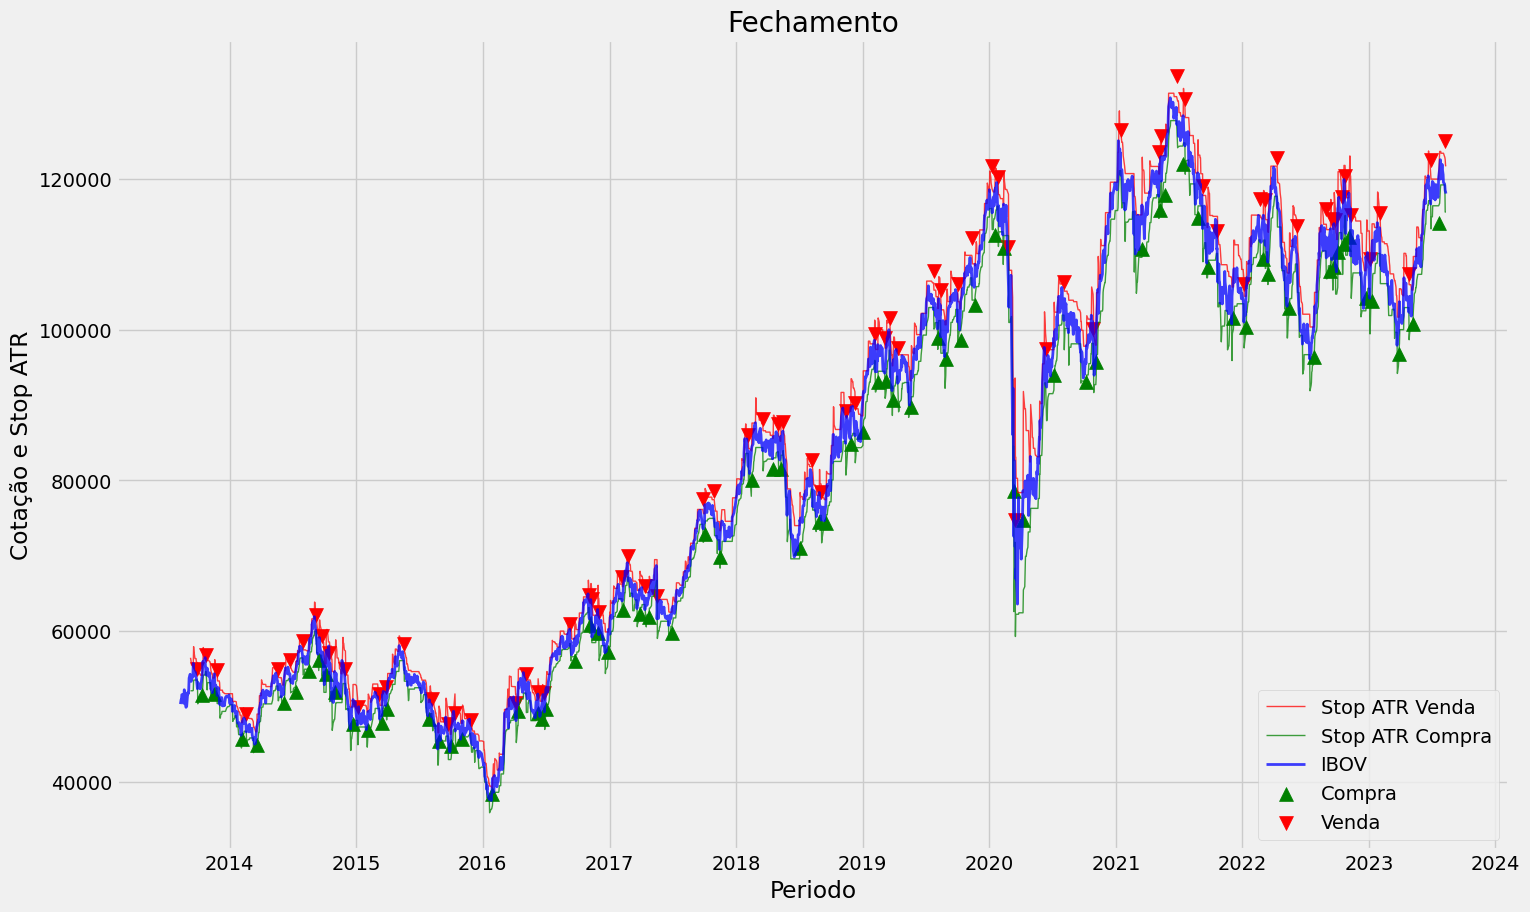

In [11]:
plt.figure(figsize = (16, 10))
plt.plot(backtesting["Stop ATR V"], label = "Stop ATR Venda", alpha = 0.75, linewidth = 1, color = "red")
plt.plot(backtesting["Stop ATR C"], label = "Stop ATR Compra", alpha = 0.75, linewidth = 1, color = "green")
plt.plot(df["Close"], label = "IBOV", alpha = 0.75, linewidth = 2, color = "blue")
plt.scatter(backtesting.index, backtesting["Compra"]*0.95, label = "Compra", marker = "^", s = 100, color = "green")
plt.scatter(backtesting.index, backtesting["Venda"]*1.05, label = "Venda", marker = "v", s = 100, color = "red")
plt.title("Fechamento")
plt.xlabel("Periodo")
plt.ylabel("Cotação e Stop ATR")
plt.legend(loc = "lower right")
plt.show()

In [12]:
df_compra = backtesting[ ~ backtesting["Compra"].isna()]
np.array(df_compra["Compra"])
df_venda = backtesting[ ~ backtesting["Venda"].isna()]
np.array(df_venda["Venda"])
print(df_compra.shape)
print(df_venda.shape)

(78, 5)
(79, 5)


In [13]:
resultado = round(sum(np.array(df_venda["Venda"][:-1])-np.array(df_compra["Compra"])), 2)
#resultado = round(sum(np.array(df_venda["Venda"])-np.array(df_compra["Compra"])), 2)
print("Resultado por ação: R$ " + str(resultado))

Resultado por ação: R$ -64254.0


In [14]:
df_compra_reset = df_compra.reset_index().add_suffix('_c')
df_venda_reset = df_venda.reset_index().add_suffix('_v')


# Concatenação dos DataFrames
df_union = pd.concat([df_compra_reset, df_venda_reset], axis=1)
df_union.dropna(axis=1, how='all', inplace=True)

In [15]:
df_union['Rentabilidade'] = (df_union['Venda_v']-df_union['Compra_c'])/df_union['Compra_c']*100

In [16]:
df_union['Rentabilidade_Acum'] = df_union['Rentabilidade'].cumsum()

In [17]:
df_union

,Date_c,Close_c,Stop ATR C_c,Stop ATR V_c,Compra_c,Date_v,Close_v,Stop ATR C_v,Stop ATR V_v,Venda_v,Rentabilidade,Rentabilidade_Acum
0,2013-10-14,54171.0000,51409.2000,54129.7000,54171.0000,2013-09-30,52338.0000,53486.7000,55803.1000,52338.0000,-3.3837,-3.3837
1,2013-11-18,54307.0000,51548.6000,53762.4000,54307.0000,2013-10-25,54154.0000,54601.4000,56829.8000,54154.0000,-0.2817,-3.6655
2,2014-02-07,48074.0000,45993.0000,47834.6000,48074.0000,2013-11-25,52264.0000,52421.9000,54637.6000,52264.0000,8.7157,5.0503
3,2014-03-20,47278.0000,44898.3000,46618.0000,47278.0000,2014-02-18,46600.0000,46694.1000,49368.8000,46600.0000,-1.4341,3.6162
4,2014-06-06,53129.0000,50457.9000,52830.3000,53129.0000,2014-05-20,52366.0000,52690.3000,54928.9000,52366.0000,-1.4361,2.1801
...,...,...,...,...,...,...,...,...,...,...,...,...
74,2023-01-09,109227.0000,104048.7000,108903.2000,109227.0000,2023-01-03,104166.0000,105488.2000,111118.0000,104166.0000,-4.6335,-65.2522
75,2023-03-29,101793.0000,97501.7000,101668.1000,101793.0000,2023-02-02,109935.0000,110120.7000,115633.8000,109935.0000,7.9986,-57.2536
76,2023-05-08,106042.0000,101427.9000,105259.7000,106042.0000,2023-04-26,102312.0000,102929.1000,106849.2000,102312.0000,-3.5175,-60.7711
77,2023-07-21,120217.0000,116443.3000,119987.4000,120217.0000,2023-06-28,116681.0000,117121.5000,120965.6000,116681.0000,-2.9413,-63.7124


<Axes: >

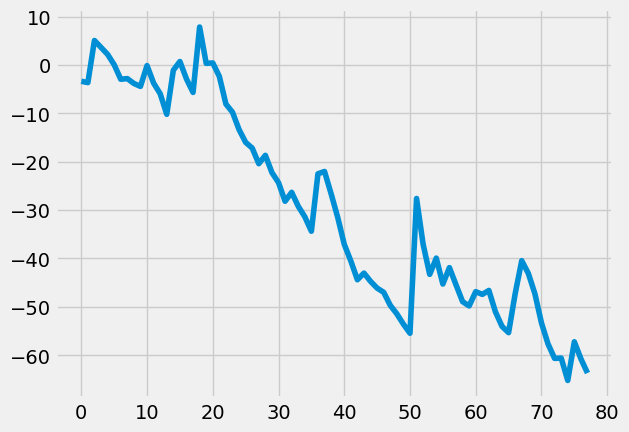

In [18]:
df_union['Rentabilidade_Acum'].plot()